In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
import pandas as pd
import seaborn as sns
from binaryflow import quantizers
from binaryflow.layers import ABCNet,XnorNet,BinaryNet
from binaryflow.block import BiRealNet
from binaryflow.layers.normalization import *
from contextlib import redirect_stdout
import json
import matplotlib.pyplot as plt


2022-08-10 12:34:46.005641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 12:34:46.034027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 12:34:46.034232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 12:34:46.035226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
  data_format="channels_last"
    
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()
X_train=X_train.astype(dtype=np.float32)
y_train=tf.one_hot(y_train,10)
X_test=X_test.astype(dtype=np.float32)
X_train=X_train.reshape([*X_train.shape,1])
X_test=X_test.reshape([*X_test.shape,1])
# All quantized layers except the first will use the same options

abc_args = dict(
              kernel_quantizers=quantizers.ShiftedSteSign,
              input_quantizers=quantizers.ShiftedSteSign,
                kernel_estimators=5,
              kernel_constraint="weight_clip",
              kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
              use_bias=False
              )

bnn_args=dict(kernel_quantizer="ste_sign",
              input_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

Args=[bnn_args]*2+[abc_args]

Archs=[BinaryNet.QuantDense,XnorNet.ScaledQuantDense,ABCNet.ABCDense]
Names=["BinaryNet","XnorNet","ABCNet"]



Dense=BiRealNet.BiRealDense
Conv2D=XnorNet.ScaledQuantPlusConv2D


            



In [ ]:

models=[]

model=tf.keras.models.Sequential([
tf.keras.layers.GaussianNoise(stddev=4),
ImageNormalizationLayer(),
#tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),

#Conv2D(100,kernel=(3,3),mode=2,**bnn_args,activation="relu"),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),

ABCNet.ABCDense(1024,activation="relu",**abc_args),
#tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(estimator_type=ABCNet.ABCDense,**abc_args).add(tf.keras.layers.BatchNormalization(momentum=0.999,scale=False)),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Dense(10),
tf.keras.layers.Activation("softmax")
])
models.append(model)
model.compile(
tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
loss="categorical_crossentropy",
metrics=["accuracy"],
)


trained_model = model.fit(
    X_train, 
    y_train,
    batch_size=128, 
    epochs=1,
    validation_data=(X_test, tf.one_hot(y_test, 10)),
    shuffle=True
)

In [42]:
model2=tf.keras.models.load_model("local/Test")

In [11]:
class CallbackRegistrable():
    def __init__(self):
        self.onFitCallbacks=[]
        self.beforeFitCallbacks=[]
        self.onFitResults={}
        self.beforeFitResults={}
    
    def registerOnFitCallback(self,name:str,callbackFn):
        self.onFitCallbacks.append((name,callbackFn))
        self.onFitResults[name]=[]

    def registerBeforeFitCallback(self,name:str,callbackFn):
        self.beforeFitCallbacks.append((name,callbackFn))
        self.beforeFitResults[name]=[] 
    
    def onModelFit(self,index,model,name,count):
        for callbackName,callback in self.onFitCallbacks:
            self.onFitResults[callbackName].append(callback(index,model,name,count))
            
    def beforeModelFit(self,index,model,name,count):
        for callbackName,callback in self.beforeFitCallbacks:
            self.beforeFitResults[callbackName].append(callback(index,model,name,count))
    

class TrainingSimulation(CallbackRegistrable):
    def __init__(self,name:str,Dense,count:int,architecture="standard",**dense_kwargs):
        super(TrainingSimulation,self).__init__()
        self.name=name
        self.count=count
        if architecture == "standard":
            architectureCaller=TrainingSimulation.standardArchitecture
        elif achitecture == "refined":
            architectureCaller=TrainingSimulation.refinedArchitecture
        else:
            raise RuntimeError(f"Unrecognized architecture {architecture}")
        self.models=[architectureCaller(Dense,**dense_kwargs) for i in range(count)]
    
    @staticmethod
    def standardArchitecture(Dense,**dense_kwargs):
            return tf.keras.Sequential([
ImageNormalizationLayer(),
#tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),

#Conv2D(100,kernel=(3,3),mode=2,**bnn_args,activation="relu"),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(1024,activation="relu",**dense_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),            
Dense(1024,activation="relu",**dense_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(10,**dense_kwargs),
tf.keras.layers.Activation("softmax")
])
        
    @staticmethod
    def refinedArchitecture(Dense,**dense_kwargs):
        return tf.keras.Sequential([tf.keras.layers.GaussianNoise(stddev=4),
ImageNormalizationLayer(),
#tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),

#Conv2D(100,kernel=(3,3),mode=2,**bnn_args,activation="relu"),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(1024,activation="relu",**dense_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),            
Dense(1024,activation="relu",**dense_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(10),
tf.keras.layers.Activation("softmax")
])
    
    def compile(self,optimizer="adam",loss="categorical_crossentropy",metrics=None):
        if metrics is None:
            metrics=["accuracy"]
        for model in self.models:
            model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

    
    def fit(self,X_train,y_train,X_test,y_test,batch_size,epochs,shuffle=True):
        for index,model in enumerate(self.models):
            self.beforeModelFit(index,model,self.name,self.count)
            model.fit(X_train,y_train,batch_size=batch_size,validation_data=(X_test,y_test),shuffle=shuffle,epochs=epochs)
            self.onModelFit(index,model,self.name,self.count)
    
    def generateSummary(self):
        U=pd.DataFrame()
        for index,model in enumerate(self.models):
            V=pd.DataFrame.from_dict(model.history.history)
            V["index"]=index
            V["epoch"]=np.arange(V.shape[0])+1
            U=pd.concat([U,V],ignore_index=True)
        U["name"]=self.name
        return U
    
class TrainingSimulations():
    def __init__(self,name,simulations=None):
        self.name=name
        if simulations is None:
            self.simulations=[]
        else:
            self.simulations=simulations
        self.beforeSimulationCallbacks={}
        self.onSimulationCallbacks={}
        
    def add(self,simulation:TrainingSimulation):
        self.simulations.append(simulation)

    def compile(self,optimizer="adam",loss="categorical_crossentropy",metrics=None):
        for simulation in self.simulations:
            simulation.compile(optimizer,loss,metrics)
    
    def fit(self,X_train,y_train,X_test,y_test,batch_size,epochs,shuffle=True):
        for index,simulation in enumerate(self.simulations):
            self.beforeSimulation(index,simulation,self.name)
            simulation.fit(X_train,y_train,X_test,y_test,batch_size,epochs,shuffle)
            self.onSimulation(index,simulation,self.name)
            
    def registerBeforeSimulationCallback(self,name,callbackFn):
        self.beforeSimulationCallbacks[name]=callbackFn
        
    def registerOnSimulationCallback(self,name,callbackFn):
        self.onSimulationCallbacks[name]=callbackFn
        
    def onSimulation(self,index,simulation,name):
        for callbackName in self.onSimulationCallbacks:
            self.onSimulationCallbacks[callbackName](index,simulation,name)
        
    def beforeSimulation(self,index,simulation,name):
        for callbackName in self.beforeSimulationCallbacks:
            self.beforeSimulationCallbacks[callbackName](index,simulation,name)

    def registerOnFitCallback(self,name:str,callbackFn):
        for simulation in self.simulations:
            simulation.registerOnFitCallback(name,callbackFn)

    def registerBeforeFitCallback(self,name:str,callbackFn):
        for simulation in self.simulations:
            simulation.registerBeforeFitCallback(name,callbackFn)
    
    def generateSummary(self):
        return pd.concat([ simulation.generateSummary() for simulation in self.simulations],ignore_index=True)
    

In [5]:
def outputSimulationIndex(index,model,name,count):
    print(f"Simulation {index+1}/{count} of {name}. on MNIST")

    
def outputNewSimulation(index,simulation,name):
    print(f"Beginning Simulation of {simulation.name}")

In [12]:
count=10
epochs=30



BinaryNetSimulation=TrainingSimulation("BinaryNet",BinaryNet.QuantDense,count,**bnn_args)
XnorNetSimulation=TrainingSimulation("XnorNet",XnorNet.XnorDense,count,**bnn_args)
ABCNetSimulation=TrainingSimulation("ABCNet",ABCNet.ABCDense,count,**abc_args)

MNISTSimulations=TrainingSimulations("MNIST",[BinaryNetSimulation,XnorNetSimulation,ABCNetSimulation])

MNISTSimulations.compile(tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),"categorical_crossentropy",["accuracy"])
MNISTSimulations.registerBeforeFitCallback("LOG_SIMULATION",outputSimulationIndex)
MNISTSimulations.registerBeforeSimulationCallback("LOG_EXPERIENCE",outputNewSimulation)
MNISTSimulations.fit(X_train,y_train,X_test,tf.one_hot(y_test,10),batch_size=128,epochs=epochs,shuffle=True)
results=MNISTSimulations.generateSummary()
results.save("local/simulation_results.csv")

Beginning Simulation of BinaryNet
Simulation 1/10 of BinaryNet. on MNIST
Epoch 1/30
469/469 [==============================] - 4s 7ms/step - loss: 6.6815 - accuracy: 0.8626 - val_loss: 54.5398 - val_accuracy: 0.2458
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 4.1024 - accuracy: 0.9086 - val_loss: 53.9973 - val_accuracy: 0.2576
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 3.3105 - accuracy: 0.9211 - val_loss: 32.1519 - val_accuracy: 0.4419
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 2.6653 - accuracy: 0.9328 - val_loss: 39.8074 - val_accuracy: 0.3486
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 2.3315 - accuracy: 0.9406 - val_loss: 37.6132 - val_accuracy: 0.3852
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 1.9703 - accuracy: 0.9481 - val_loss: 33.2212 - val_accuracy: 0.4648
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - l

AttributeError: 'DataFrame' object has no attribute 'save'

<AxesSubplot:xlabel='epoch', ylabel='val_accuracy'>

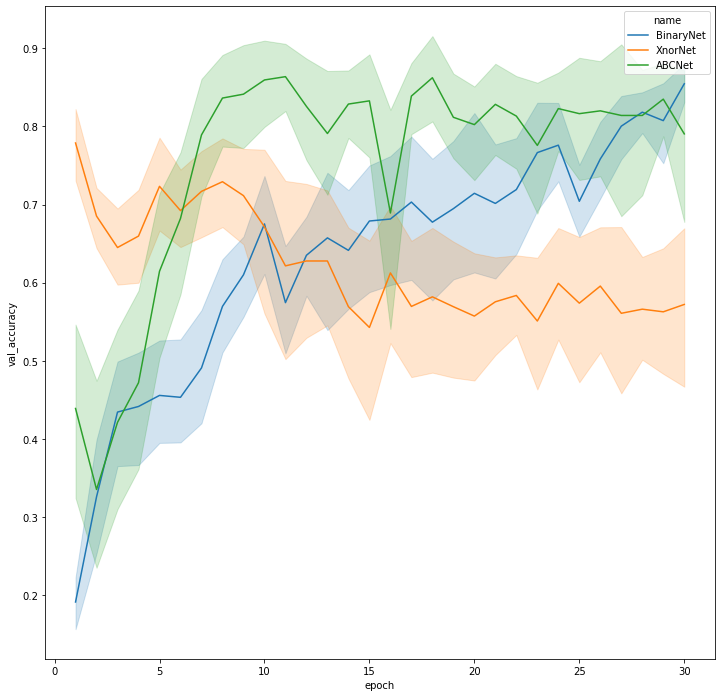

In [13]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(12,12))
sns.lineplot(data=results,x="epoch",y="val_accuracy",hue="name")

In [15]:
results

,loss,accuracy,val_loss,val_accuracy,index,epoch,name
0,6.498869,0.819833,11.617703,0.6906,0,1,BinaryNet
1,4.266519,0.873550,7.908916,0.7523,0,2,BinaryNet
2,3.446828,0.896733,2.531591,0.9067,0,3,BinaryNet
3,2.757224,0.911617,8.231625,0.7538,0,4,BinaryNet
4,2.547709,0.916150,2.699282,0.8981,0,5,BinaryNet
...,...,...,...,...,...,...,...
895,0.034581,0.988667,0.155811,0.9495,9,26,ABCNet
896,0.032562,0.989017,0.357620,0.8840,9,27,ABCNet
897,0.033826,0.988633,0.183931,0.9384,9,28,ABCNet
898,0.030917,0.989367,0.121735,0.9656,9,29,ABCNet


In [19]:
epochs=30
count=10
XnorNetSimulation=TrainingSimulation("XnorNet",XnorNet.ScaledQuantDense,count,**bnn_args,alpha_trainable=True)
XnorNetSimulation.compile(tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),"categorical_crossentropy",["accuracy"])
XnorNetSimulation.registerBeforeFitCallback("LOG_SIMULATION",outputSimulationIndex)
XnorNetSimulation.fit(X_train,y_train,X_test,tf.one_hot(y_test,10),batch_size=128,epochs=epochs,shuffle=True)


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Simulation 1/10 of XnorNet. on MNIST
Epoch 1/30
469/469 [==============================] - 5s 9ms/step - loss: 0.3101 - accuracy: 0.9042 - val_loss: 11.4731 - val_accuracy: 0.1229
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2197 - accuracy: 0.9338 - val_loss: 22.1811 - val_accuracy: 0.1628
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1722 - accuracy: 0.9465 - val_loss: 33.5702 - val_accuracy: 0.2216
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1521 - accuracy: 0.9527 - val_loss: 37.0733 - val_accuracy: 0.2610
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1373 - accuracy: 0.9556 - val_loss: 46.3633 - val_accuracy: 0.1095
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1200 - accuracy: 0.9611 - val_loss: 29.0449 - val_accuracy: 0.1734
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1120 - accuracy: 0.9646 - val

KeyboardInterrupt: 

In [14]:
results.to_csv("local/simulation-results.csv")